In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

Undrift!

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
  7.0
 -3.0
  5.9137995217164026
 16.296452344106253
 13.895510102105376
 12.691488283559217
  6.969259834997379
  1.4428516416456016
  4.877836216688191
  5.192767884171211
  ⋮
 -1.8020565459185436
 -9.473451526488335
  5.491228174090816
 -1.2579565925178118
  1.7562412440937516
 -3.5070219873753
  7.699889486179199
  0.5544702150706604
  5.923730539527165

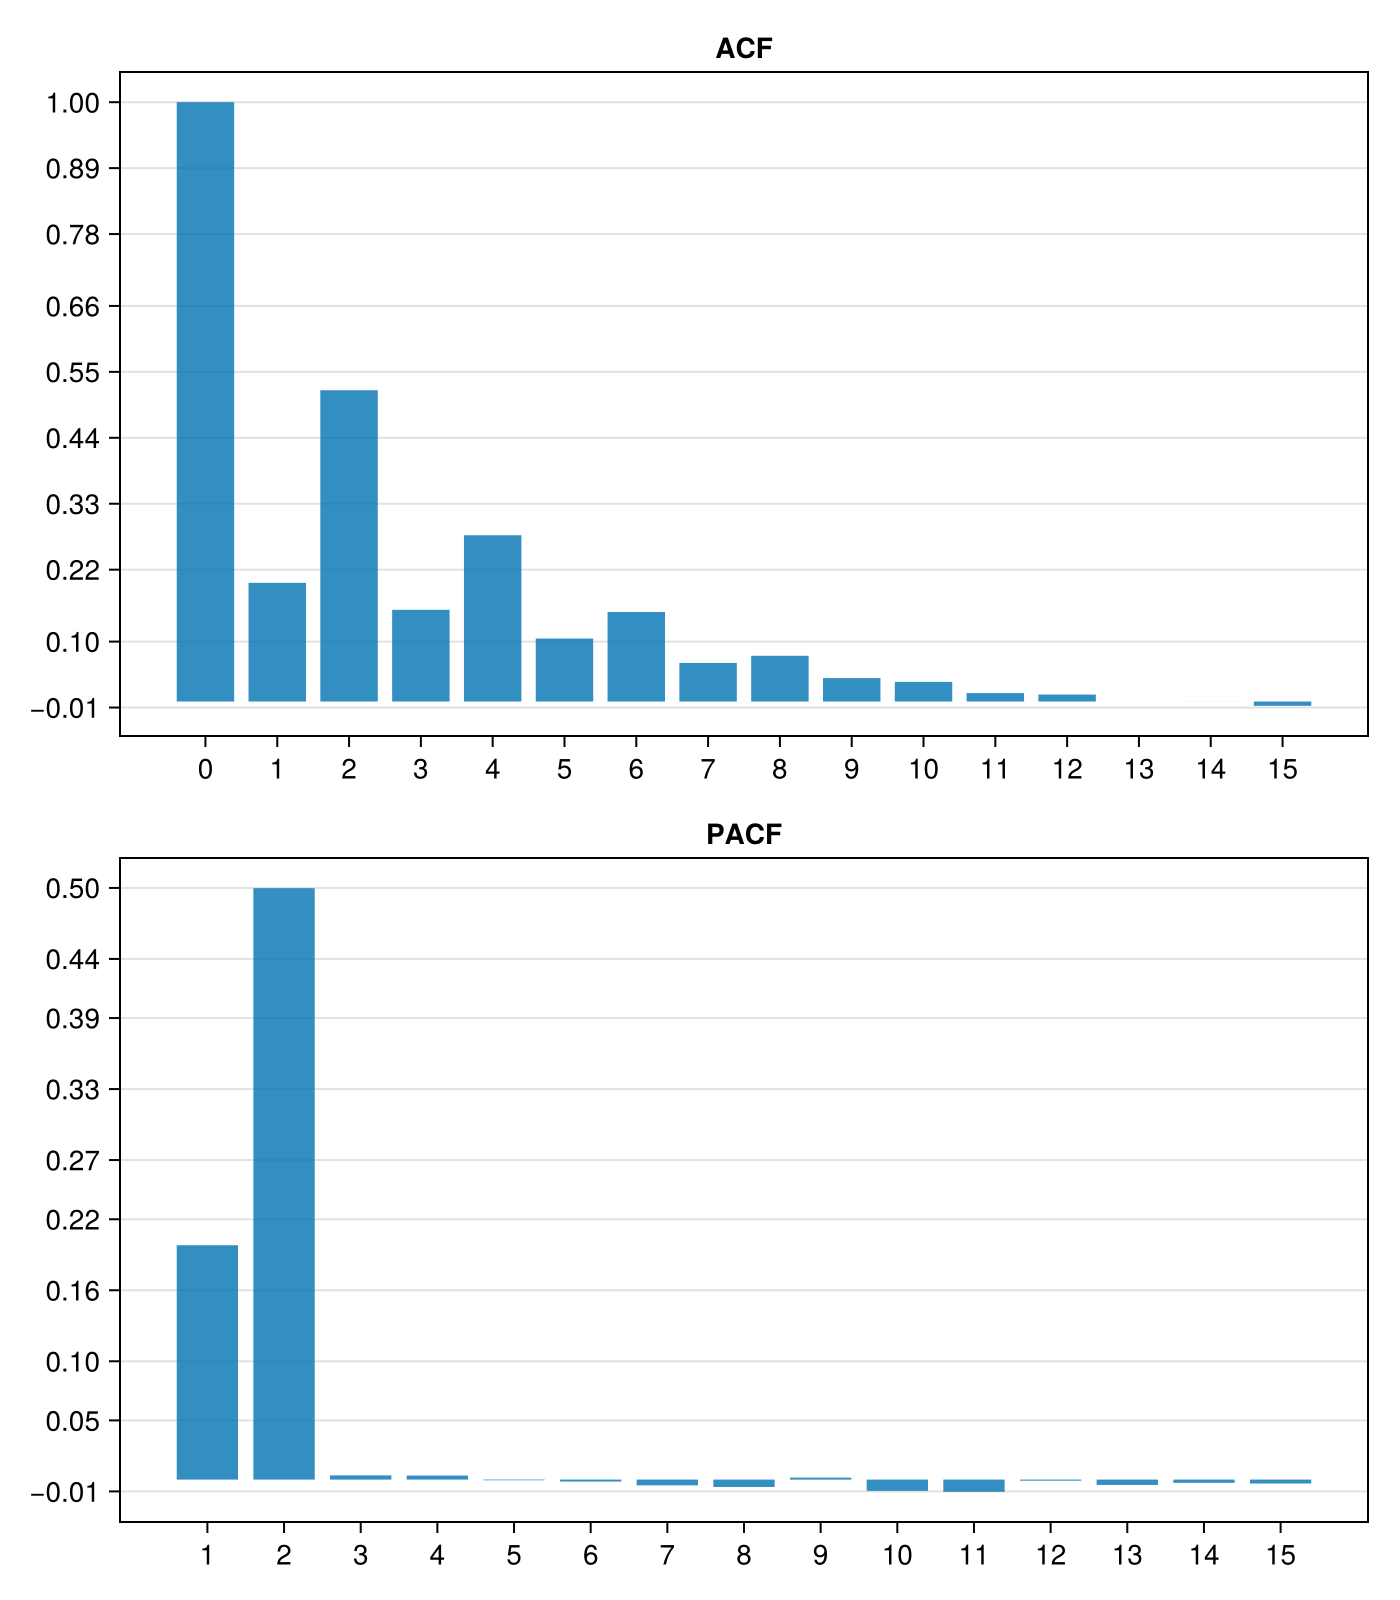

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.000877216,0.00877216
2,Φ₂,0.000194798,0.000389597
3,σ,0.0250949,0.00418249


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

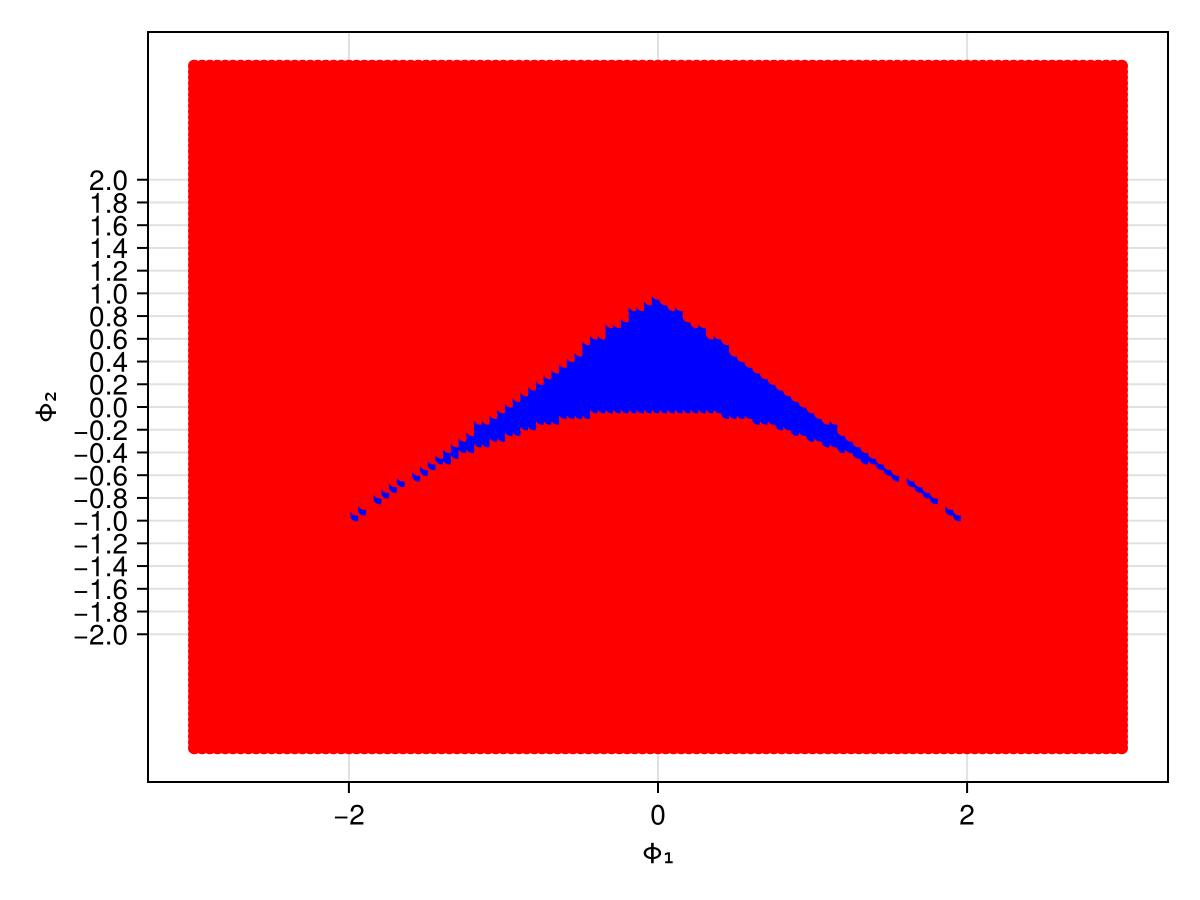

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [10]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,2),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{AbstractVector}}:
 [[-5.808169060050202, -4.833766469773957, -2.7125451455302008, -4.524002377112111, 0.4785140396096632, -1.6464007191099128, -1.627957636483478, -2.102141563760207, -0.24454865991889485, 0.6601301276850692  …  2.9145575046049528, 4.100398230064817, 1.6256026634351997, 1.0336269325644465, -1.8088894917339073, 0.19317944064158854, 1.3960286558020687, -1.646098900563958, -3.689904829058472, -6.060009443157107], [4.153204816669122, 4.656979014306829, 4.634804401946461, 3.5612135097203375, 6.277164737676568, 2.5013787611294127, 1.3441865892041855, -0.963316803269366, 1.0254306526547572, 0.5548121931747876  …  3.2942709908104644, 2.1389401950430624, 0.6484992488981378, -2.41984280858303, -1.1790324432298207, -2.2229153702473177, -3.9427815475805703, -1.940344656315803, -2.185176494474964, -0.5352489955590949], [-4.821885855811768, -3.117844651419107, -2.1254753654153826, -3.0610404682247845, -0.1385770568081961, 0.31372469982973217, 0.17506644147801

## Autocorrelations

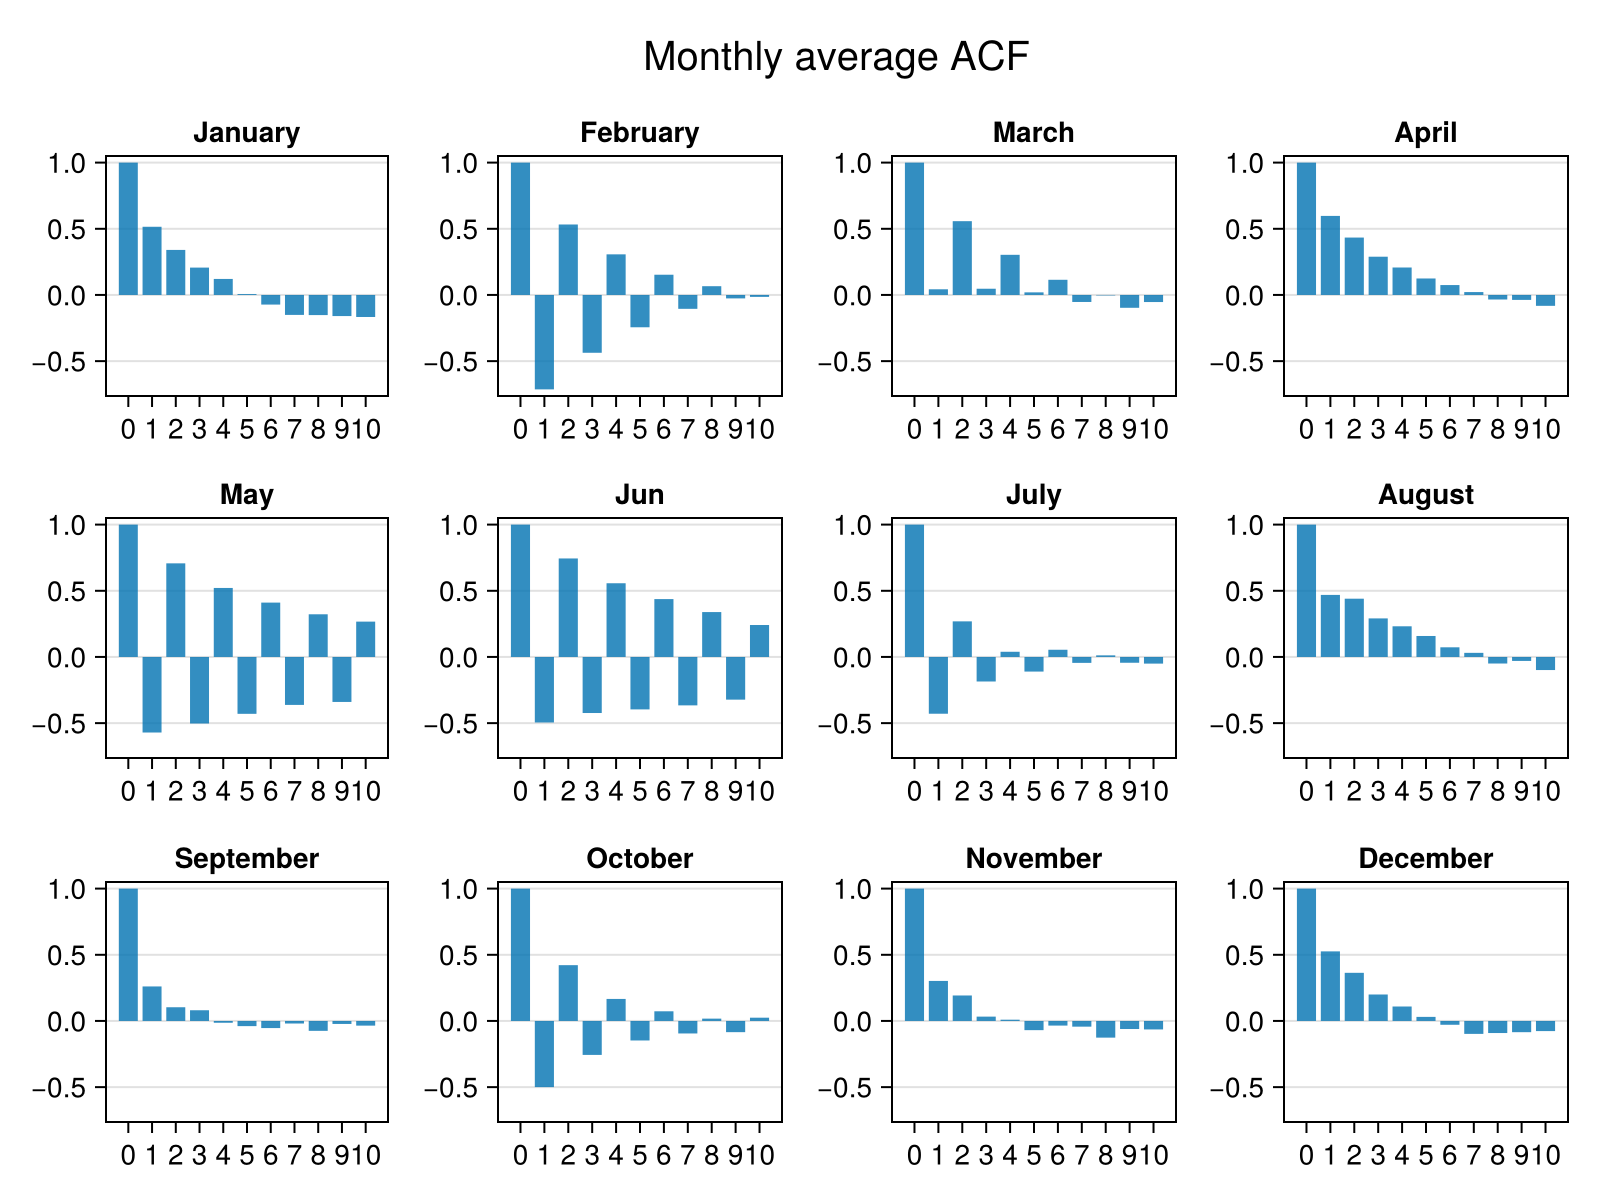

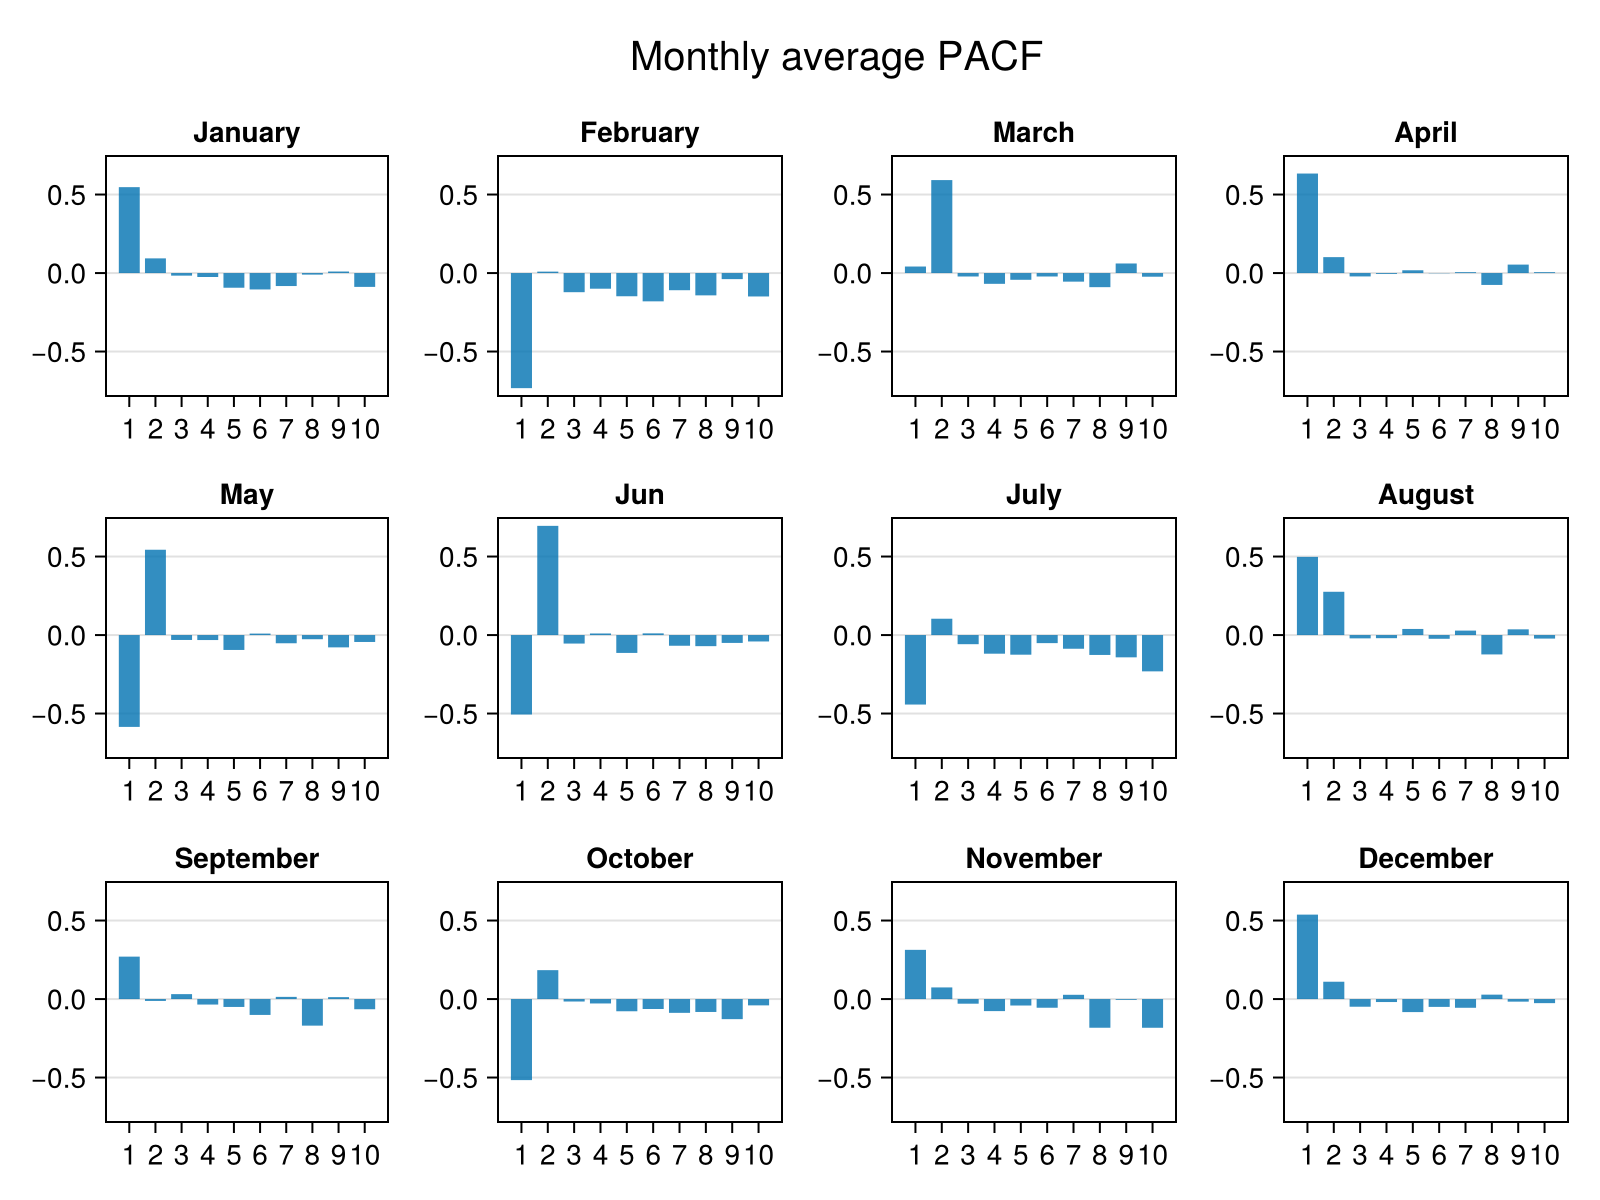

CairoMakie.Screen{IMAGE}


In [11]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

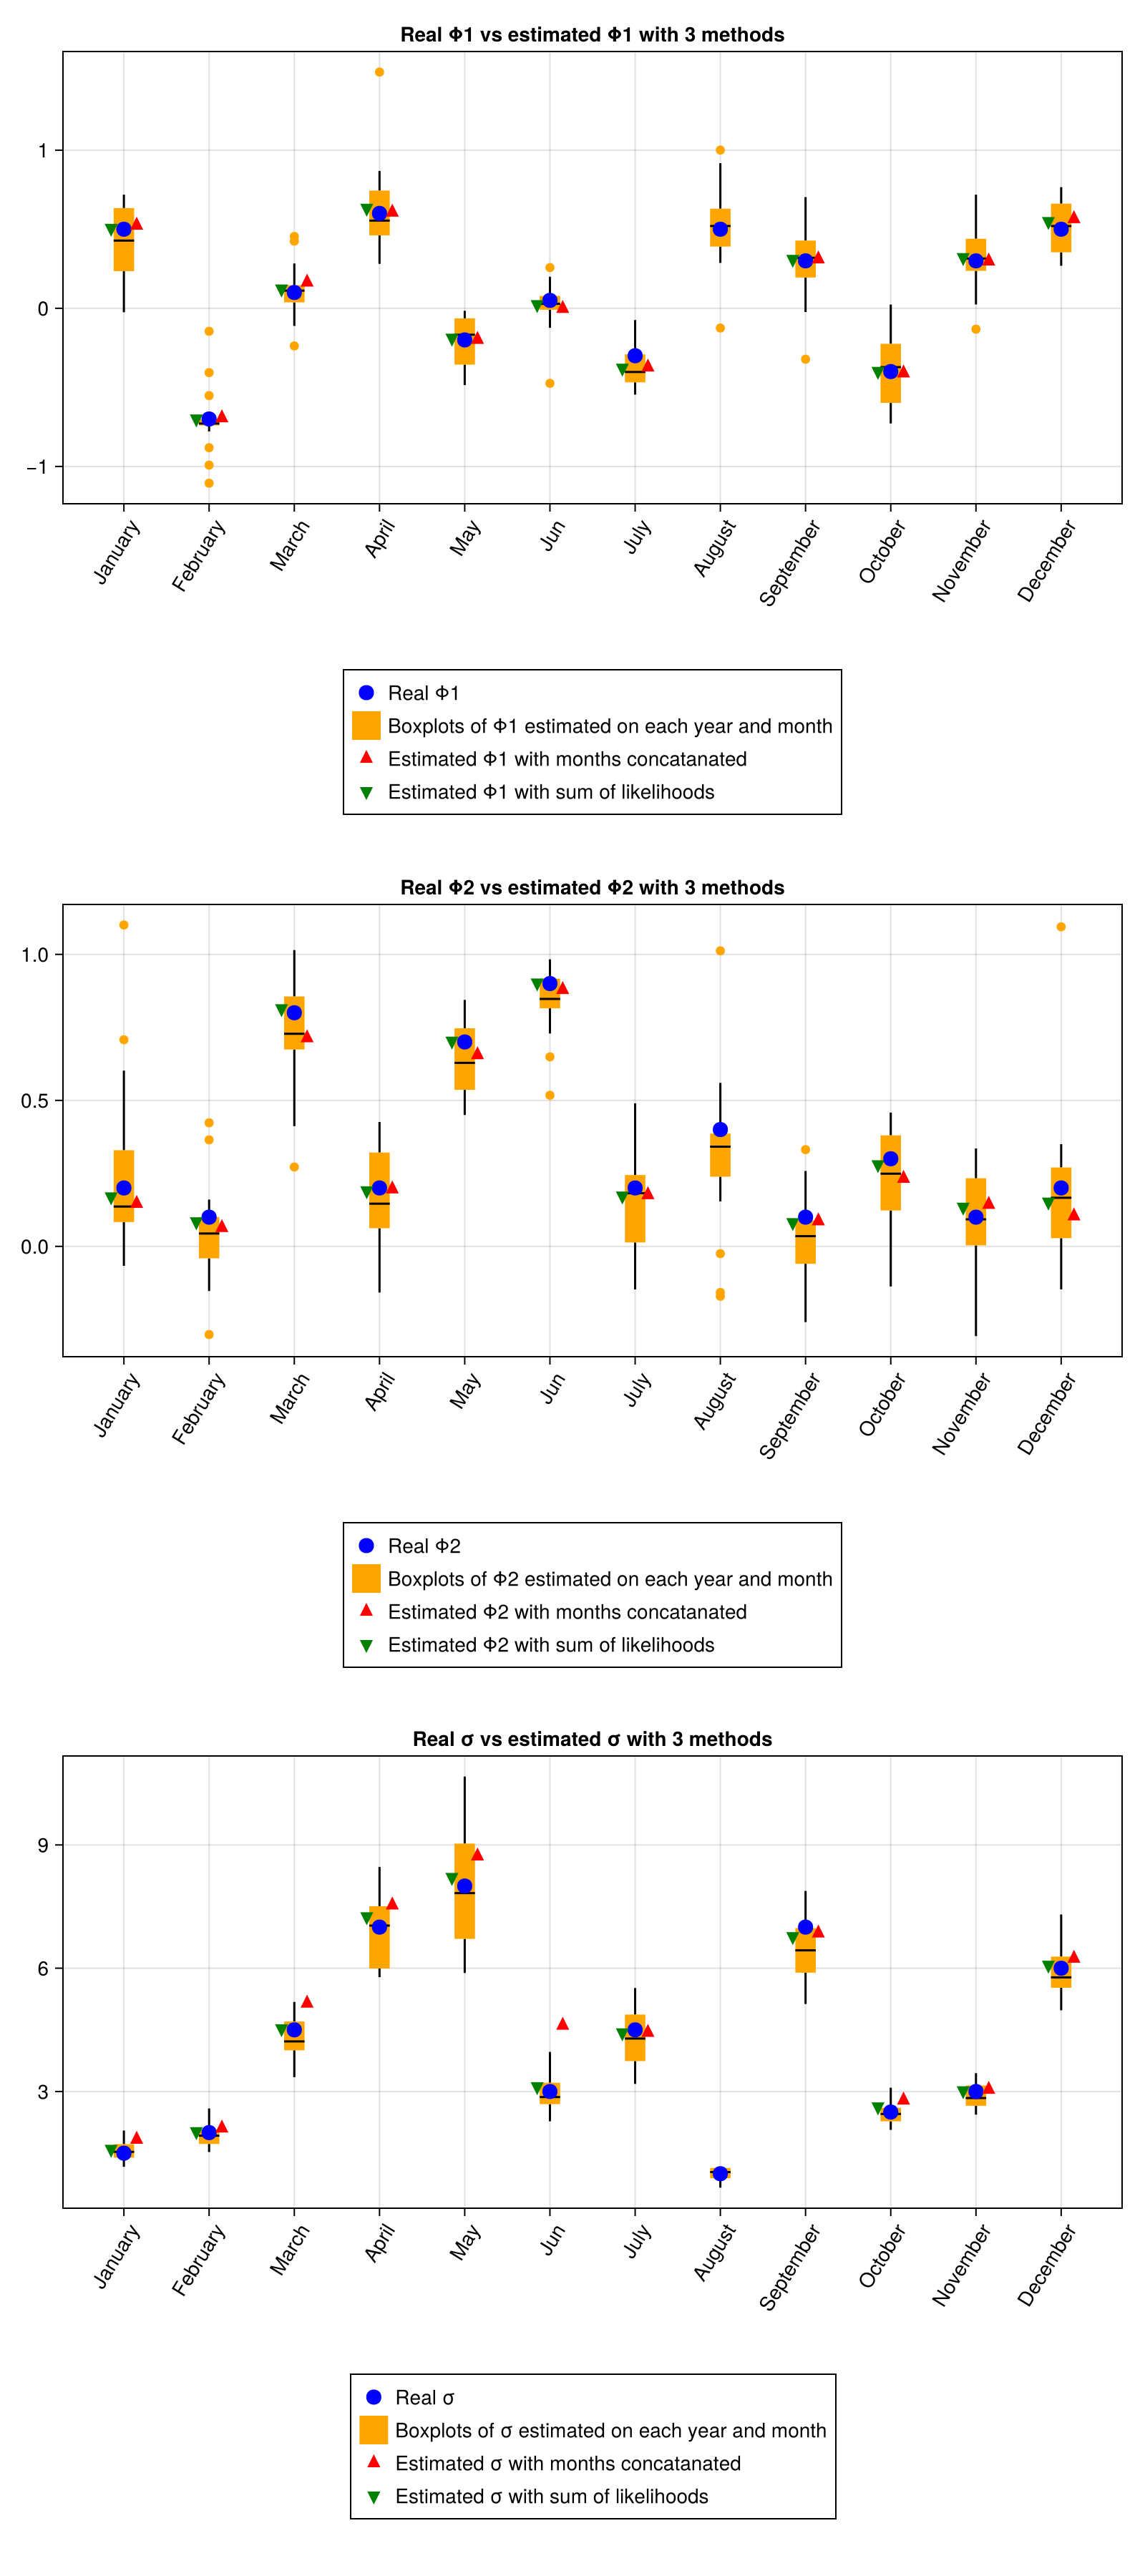

Row,Parameter,Month concatanation,Sum LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64
1,Φ1,6.26132e152,1.58008e153,12.4181,13.1839
2,Φ2,7.52695e153,1.89946e154,23.6587,22.4768
3,σ,1.42792e77,2.26835e77,2.68788,3.9157


6

In [12]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month])
display(autofig)
display(ErrorTable)

In [13]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=10
sim=SimulateScenarios([4.,3.],Date(2001,1,1):(Date(2001,1,1) + Year(n_years-1)),Φ_vec, σ_vec,n=10)
sample_=GatherYearScenarios(sim,Date(2001,1,1):(Date(2001,1,1) + Year(n_years-1)))

366-element Vector{Vector{AbstractFloat}}:
 [4.0, 9.626406781284663, 1.4622531618287153, 7.3162498346835845, 7.401072399159716, 2.0454261607905626, 5.9835353319181275, 4.784091669831376, 5.653902610855917, -6.766566231586939  …  4.0, -6.687538953979376, 1.4713460034038428, 3.0439704439427997, 0.16313618602509772, -4.6639510543905125, -0.7871112090271668, 2.4257141679664977, 7.148778752477771, -6.150131073462731]
 [3.0, 7.724653378389852, 1.0985122020936553, 6.858697299716959, 9.118000413574869, 3.0618616166311177, 5.475305142215534, 4.999794073766722, 4.568546451569199, 3.0  …  -5.0782058466458535, 3.0, -4.87514776143472, -1.5554848529183871, 2.777517969573527, 0.7157870678798892, -6.604172942481442, 1.0244656797198823, 1.1212548358511072, 3.693100221789294]
 [0.36862367657422124, 6.3406789506422125, -0.3635402376010376, 5.6811053172926, 5.28468027389935, 0.8694277355697234, 5.905343549161543, 1.3198520904139863, 4.295470944858845, 3.9147089877382175  …  -6.324053766884838, 1.496943013

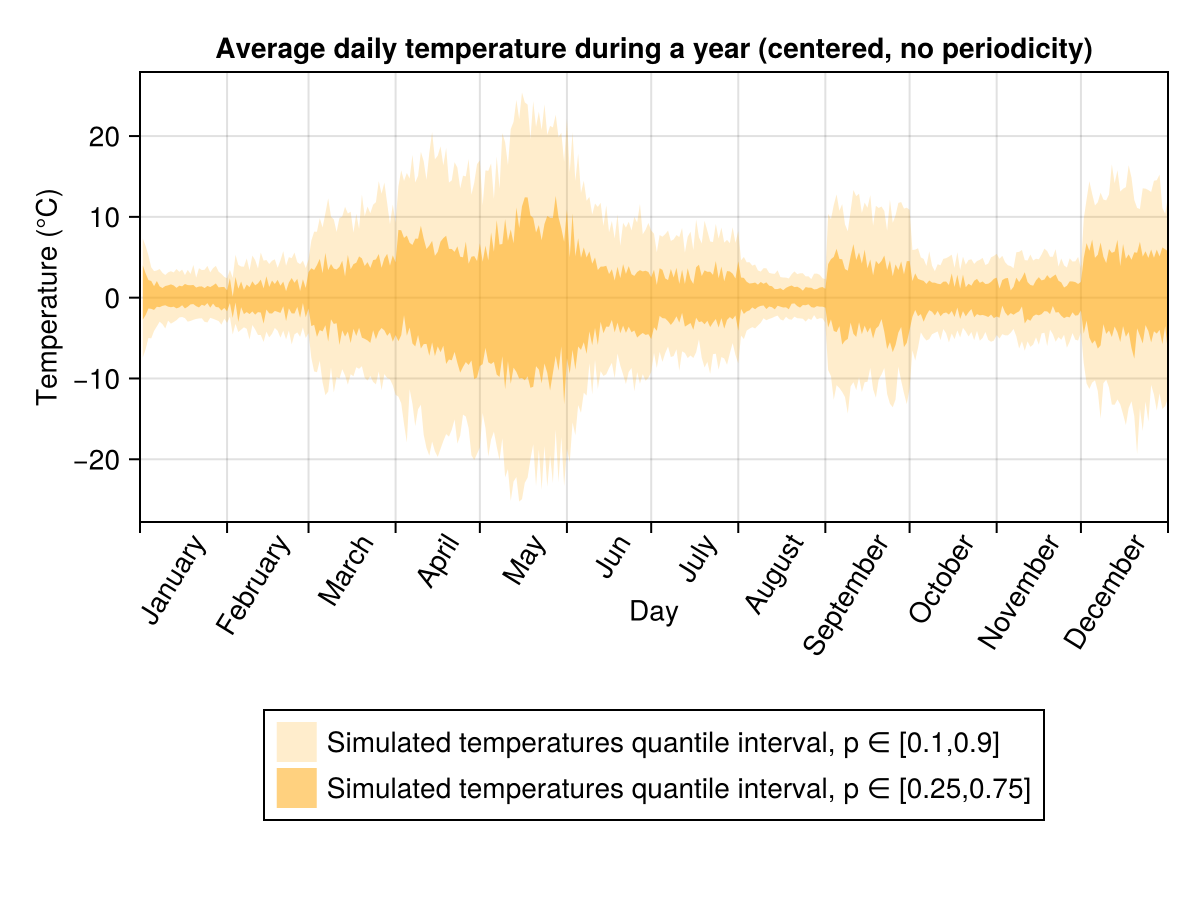

In [14]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)